# Dealing with missing values

In [6]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import pickle

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer

import missingno as msno

In [32]:
houses = pd.read_csv('data/houses.csv')

houses.head()

,Order,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,...,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price,Longitude,Latitude
0,1,526301100,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141,31770,Pave,No_Alley_Access,Slightly_Irregular,Lvl,...,No_Fence,NaN,0,5,2010,WD,Normal,215000,-93.619754,42.054035
1,2,526350040,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80,11622,Pave,No_Alley_Access,Regular,Lvl,...,Minimum_Privacy,NaN,0,6,2010,WD,Normal,105000,-93.619756,42.053014
2,3,526351010,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,...,No_Fence,Gar2,12500,6,2010,WD,Normal,172000,-93.619387,42.052659
3,4,526353030,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93,11160,Pave,No_Alley_Access,Regular,Lvl,...,No_Fence,NaN,0,4,2010,WD,Normal,244000,-93.617320,42.051245
4,5,527105010,Two_Story_1946_and_Newer,Residential_Low_Density,74,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,...,Minimum_Privacy,NaN,0,3,2010,WD,Normal,189900,-93.638933,42.060899


In [34]:
columns_with_missings = houses.columns[houses.isnull().any()]

houses[columns_with_missings].isnull().sum()

# remember that missing values might be encoded as NaN, or as a string like "NaN" or "None"
# so their identification might require some additional steps
# (checking unique values, checking data types, etc.)
# which we performed at the beginning of the project [course]
# and we will not repeat it here

Mas_Vnr_Type    1775
Electrical         1
Misc_Feature    2824
dtype: int64

In [36]:
# frequency tables for these columns with missings

print('Frequency counts for Mas_Vnr_Type:')
print(houses['Mas_Vnr_Type'].value_counts(dropna=False))
print('-----------------------------------------')

print('\nFrequency counts for Electical:')
print(houses['Electrical'].value_counts(dropna=False))
print('-----------------------------------------')

print('\nFrequency counts for Misc_Feature:')
print(houses['Misc_Feature'].value_counts(dropna=False))

Frequency counts for Mas_Vnr_Type:
Mas_Vnr_Type
NaN        1775
BrkFace     880
Stone       249
BrkCmn       25
CBlock        1
Name: count, dtype: int64
-----------------------------------------

Frequency counts for Electical:
Electrical
SBrkr    2682
FuseA     188
FuseF      50
FuseP       8
NaN         1
Mix         1
Name: count, dtype: int64
-----------------------------------------

Frequency counts for Misc_Feature:
Misc_Feature
NaN     2824
Shed      95
Gar2       5
Othr       4
Elev       1
TenC       1
Name: count, dtype: int64


In [38]:
# lets create a copy of the dataset to work with
houses_miss = houses.copy()

# and introduce some missings in the dataset
# - randomly - for two categorical columns
#   and two numerical columns (5% and 20% of the data)
# - non-randomly for two categorical columns
#   and two numerical columns (5% and 20% of the data)

In [40]:
# check frequency tables for 2 selected categorical columns

print(houses_miss['Lot_Shape'].value_counts(dropna=False, normalize = True))

print('---------------------------------------------------------')

print(houses_miss['Exter_Qual'].value_counts(dropna=False, normalize = True))

Lot_Shape
Regular                 0.634471
Slightly_Irregular      0.334130
Moderately_Irregular    0.025939
Irregular               0.005461
Name: proportion, dtype: float64
---------------------------------------------------------
Exter_Qual
Typical      0.613993
Good         0.337543
Excellent    0.036519
Fair         0.011945
Name: proportion, dtype: float64


In [42]:
# both have similar distributions (% of categories)

# lets introduce 5% missing values in these columns

# in case of Lot_Shape we do it randomly
np.random.seed(987) # for reproducibility
houses_miss.loc[houses_miss.sample(
    frac = 0.05,
    random_state = 987
).index, 'Lot_Shape'] = np.nan


# in case of Exter_Qual we do it non-randomly
# for the first 5% of those indices
houses_miss.loc[houses_miss.index[:int(0.05 * len(houses_miss))], 'Exter_Qual'] = np.nan

In [44]:
# check % frequency tables for these columns again

print(houses_miss['Lot_Shape'].value_counts(dropna=False, normalize = True))

print('---------------------------------------------------------')

print(houses_miss['Exter_Qual'].value_counts(dropna=False, normalize = True))

Lot_Shape
Regular                 0.604778
Slightly_Irregular      0.315358
NaN                     0.049829
Moderately_Irregular    0.024915
Irregular               0.005119
Name: proportion, dtype: float64
---------------------------------------------------------
Exter_Qual
Typical      0.588737
Good         0.315358
NaN          0.049829
Excellent    0.034130
Fair         0.011945
Name: proportion, dtype: float64


In [46]:
# check another two categorical columns with similar distributions
print(houses_miss['Foundation'].value_counts(dropna=False, normalize=True))

print('----------------------------------------------')

print(houses_miss['Bsmt_Qual'].value_counts(dropna=False, normalize=True))

Foundation
PConc     0.447099
CBlock    0.424573
BrkTil    0.106143
Slab      0.016724
Stone     0.003754
Wood      0.001706
Name: proportion, dtype: float64
----------------------------------------------
Bsmt_Qual
Typical        0.437884
Good           0.416041
Excellent      0.088055
Fair           0.030034
No_Basement    0.027304
Poor           0.000683
Name: proportion, dtype: float64


In [48]:
# lets introduce 20% missing values in these columns

# in case of Foundation we do it randomly
np.random.seed(876)
houses_miss.loc[houses_miss.sample(
    frac = 0.2,
    random_state = 876
).index, 'Foundation'] = np.nan


# in case of Bsmt_Qual we do it non-randomly
# for the last 20% of those indices
houses_miss.loc[houses_miss.index[-int(0.2 * len(houses_miss)):], 'Bsmt_Qual'] = np.nan

In [50]:
# check % frequency tables for these columns again

print(houses_miss['Foundation'].value_counts(dropna=False, normalize=True))

print('----------------------------------------------')

print(houses_miss['Bsmt_Qual'].value_counts(dropna=False, normalize=True))

Foundation
PConc     0.361433
CBlock    0.336519
NaN       0.200000
BrkTil    0.085324
Slab      0.012628
Stone     0.003072
Wood      0.001024
Name: proportion, dtype: float64
----------------------------------------------
Bsmt_Qual
Typical        0.345392
Good           0.337543
NaN            0.200000
Excellent      0.073038
No_Basement    0.021843
Fair           0.021502
Poor           0.000683
Name: proportion, dtype: float64


In [52]:
# lets check summary statistics for selected numerical columns

print(houses_miss[['Open_Porch_SF', 'Wood_Deck_SF', 
                  'Gr_Liv_Area', 'First_Flr_SF']].describe())

       Open_Porch_SF  Wood_Deck_SF  Gr_Liv_Area  First_Flr_SF
count    2930.000000   2930.000000  2930.000000   2930.000000
mean       47.533447     93.751877  1499.690444   1159.557679
std        67.483400    126.361562   505.508887    391.890885
min         0.000000      0.000000   334.000000    334.000000
25%         0.000000      0.000000  1126.000000    876.250000
50%        27.000000      0.000000  1442.000000   1084.000000
75%        70.000000    168.000000  1742.750000   1384.000000
max       742.000000   1424.000000  5642.000000   5095.000000


In [54]:
# lets introduce 5% missing values in 'Open_Porch_SF', 'Wood_Deck_SF' columns

n = len(houses_miss)

# in case of Open_Porch_SF we do it randomly
np.random.seed(765) # for reproducibility - again DIFFERENT than before
houses_miss.loc[houses_miss.sample(
    frac = 0.05,
    random_state = 765
).index, 'Open_Porch_SF'] = np.nan

# in case of Wood_Deck_SF we do it randomly
# for the first 5% of those indices
houses_miss.loc[houses_miss.index[int(0.2 * n):int(0.25 * n)], 
                'Wood_Deck_SF'] = np.nan

# and 20% missing values in 'Gr_Liv_Area', 'First_Flr_SF' columns

# in case of 'Gr_Liv_Area' we do it randomly
np.random.seed(654) # for reproducibility - again DIFFERENT than before
houses_miss.loc[houses_miss.sample(
    frac = 0.2,
    random_state = 654
).index, 'Gr_Liv_Area'] = np.nan

# in case of 'First_Flr_SF' we do it non-randomly
# for the first 20% of those indices
houses_miss.loc[houses_miss.index[int(0.6 * n):int(0.8*n)],
                'First_Flr_SF'] = np.nan

In [56]:
# lets now check the number of missing values in the dataset
columns_with_missings = houses_miss.columns[houses_miss.isnull().any()]

houses_miss[columns_with_missings].isnull().sum()

Lot_Shape         146
Mas_Vnr_Type     1775
Exter_Qual        146
Foundation        586
Bsmt_Qual         586
Electrical          1
First_Flr_SF      586
Gr_Liv_Area       586
Wood_Deck_SF      146
Open_Porch_SF     146
Misc_Feature     2824
dtype: int64

## IMPORTANT !!!
The rules of dealing with missing values should be derived based on the TRAINING data only! And applied in the same way on the test data - as any data transformations that take into account distributions

In [59]:
# lets split the data randomly into train and test sets
# (we will use the same split for both datasets - with and without missings)

houses_train, houses_test = train_test_split(
    houses,
    test_size = 0.3,
    random_state = 123
)

houses_miss_train, houses_miss_test = train_test_split(
    houses_miss,
    test_size = 0.3,
    random_state = 123
)

---
To get a better understanding of missing data patterns, we can display them using functions from the missingno package

---

<Axes: >

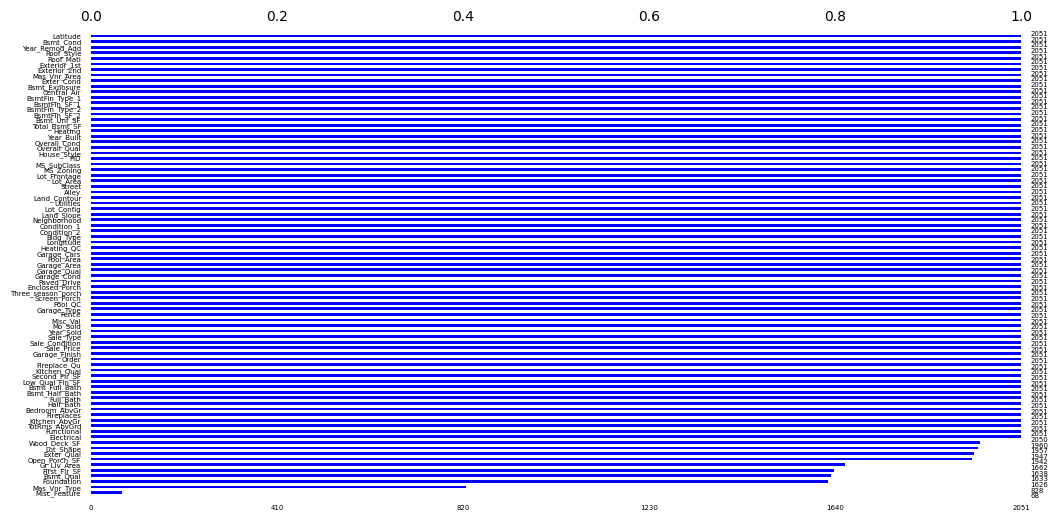

In [62]:
msno.bar(
    houses_miss_train,
    figsize = (12, 6),
    color = 'blue',
    sort = 'ascending',
    fontsize = 5
)

<Axes: >

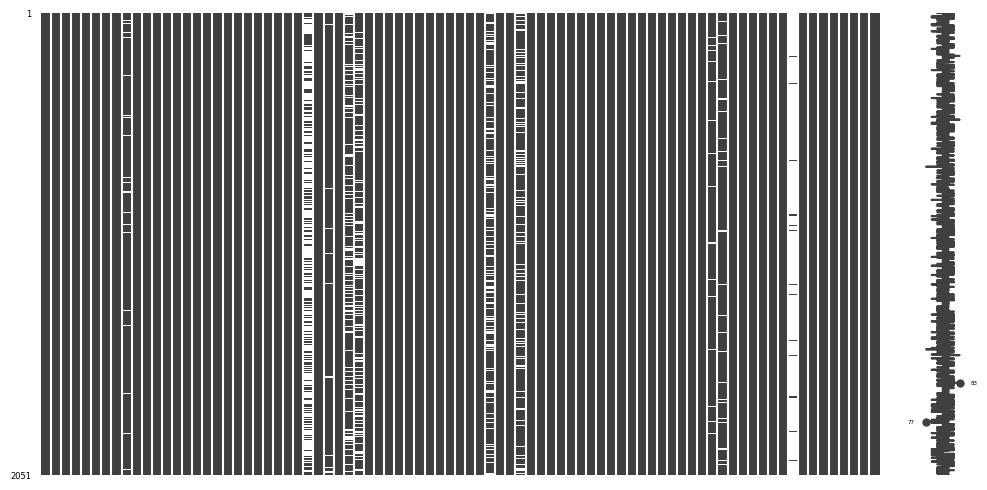

In [68]:
# To visualize this missing data pattern lets try to visualize
# the missing data location in the dataset using a matrix plot

msno.matrix(
    houses_miss_train,
    figsize = (12, 6),
    fontsize = 5
)

<Axes: >

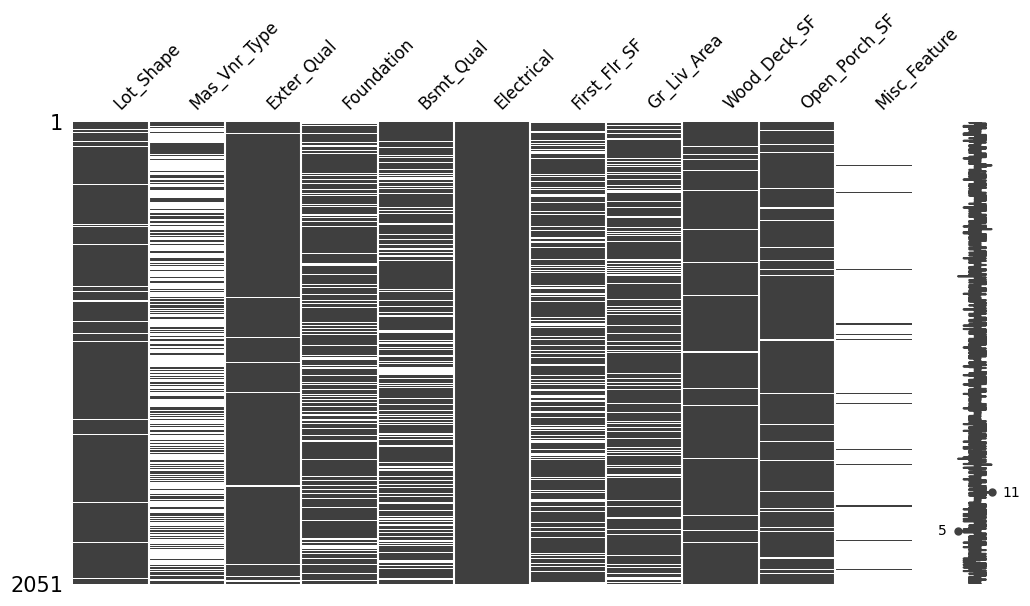

In [72]:
# it is hard to read the matrix plot with so many columns
# so lets select only the columns with missing values

missing_cols = houses_miss_train.columns[houses_miss_train.isnull().any()]

msno.matrix(
    houses_miss_train[missing_cols],
    figsize = (12, 6),
    fontsize = 12
)

# - If the color is dark, the data exists.
# - If the color is white, the data is missing.
# - A mini-graph on the right shows the overall density of missing values 
#   across the dataset.

<Axes: >

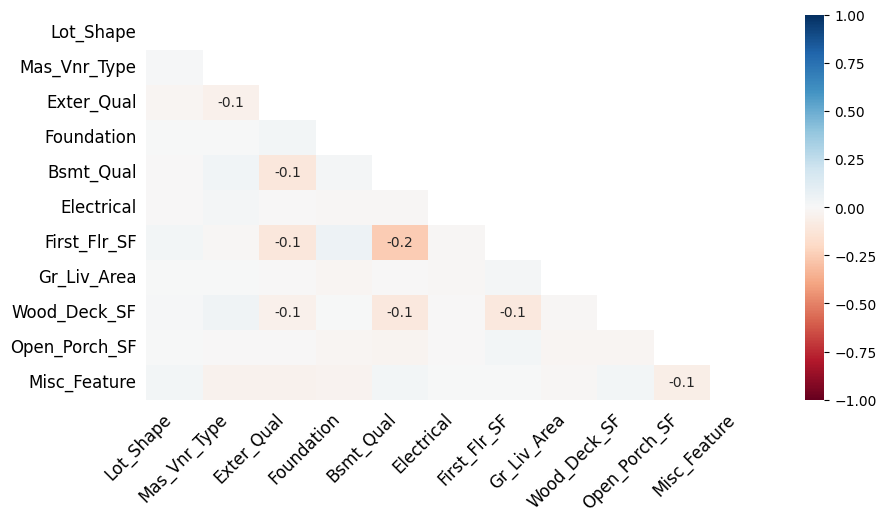

In [74]:
# we can visualize the nullity correlation (range -1 to 1)
# to measure the missing data relationship between features
msno.heatmap(
    houses_miss_train,
    figsize = (10, 5),
    fontsize = 12
)

# How to apply various approaches to missings?

## Removing missing observations

In [87]:
# lets remove all the rows with missing values in the training set
houses_miss_train_clean = houses_miss_train.dropna()

# lets check the number of observations in training set
# before and after removing rows with missings
print('Number of observations before removing missings:',
     len(houses_miss_train))
print('Number of observations after removing missings:',
     len(houses_miss_train_clean))


# IMPORTANT !!!
# this approach does not generally make sense,
# because we loose a lot of data
# and missing values might appear in the test set as well

Number of observations before removing missings: 2051
Number of observations after removing missings: 4


## Imputation
Imputation of missing data for `quantitative` variables using `mean` or `median` - each time lets also store the original columns with missings for further comparisons

In [90]:
# lets create copies of the original numerical columns with missings
quantitative_cols = ['Open_Porch_SF', 'Wood_Deck_SF',
                     'Gr_Liv_Area', 'First_Flr_SF']

houses_miss_train_copy = houses_miss_train[quantitative_cols].copy()

houses_miss_train_copy.head()

,Open_Porch_SF,Wood_Deck_SF,Gr_Liv_Area,First_Flr_SF
2278,266.0,483.0,2034.0,NaN
1379,0.0,0.0,904.0,904.0
2182,44.0,0.0,NaN,NaN
1436,70.0,0.0,1652.0,782.0
1599,0.0,187.0,NaN,546.0


In [94]:
# And replace missings for quantitative variables with sample average

# we will use simple imputation

# create an imputer object with a strategy to replace missing values with the mean
imputer_mean = SimpleImputer(strategy = 'mean')
# alternatively we could use "median" or "most_frequent"

# fit the imputer on the training set and transform the training set
houses_miss_train[quantitative_cols] = imputer_mean.fit_transform(
    houses_miss_train[quantitative_cols]
)

# of course we apply the same transformation on the test set
# (it uses means calculated on the training set)
houses_miss_test[quantitative_cols] = imputer_mean.transform(
    houses_miss_test[quantitative_cols]
)

In [96]:
# lets change the names of the columns to indicate that
# they were imputed and how

houses_miss_train.rename(
    columns = {col: col + '_mean' for col in quantitative_cols},
    inplace = True
)

# and merge this data with the dataset including the original columns
houses_miss_train = pd.concat([
    houses_miss_train, houses_miss_train_copy
], axis = 1)

In [98]:
# lets create copies of all the original columns with missings

houses_miss_train_copy2 = houses_miss_train[missing_cols].copy()

houses_miss_train_copy2.head()

,Lot_Shape,Mas_Vnr_Type,Exter_Qual,Foundation,Bsmt_Qual,Electrical,First_Flr_SF,Gr_Liv_Area,Wood_Deck_SF,Open_Porch_SF,Misc_Feature
2278,Regular,NaN,Typical,CBlock,No_Basement,SBrkr,NaN,2034.0,483.0,266.0,NaN
1379,Slightly_Irregular,BrkCmn,Typical,NaN,Typical,SBrkr,904.0,904.0,0.0,0.0,NaN
2182,Regular,Stone,Typical,NaN,Good,SBrkr,NaN,NaN,0.0,44.0,NaN
1436,Slightly_Irregular,BrkFace,Good,NaN,Good,SBrkr,782.0,1652.0,0.0,70.0,NaN
1599,Regular,NaN,Typical,CBlock,Typical,SBrkr,546.0,NaN,187.0,0.0,NaN


In [100]:
# Imputation based on the most frequent value
# can be applied also to categorical variables

# create an imputer
imputer_most_frequent = SimpleImputer(strategy = 'most_frequent')

# fit the imputer on the training set and transform the training set
houses_miss_train[missing_cols] = imputer_most_frequent.fit_transform(
    houses_miss_train[missing_cols]
)

# we will skip imputation of the test set for now
# - we already showed how to do it for quantitative variables

In [102]:
# lets change the names of the columns to indicate
# that they were imputed and how

houses_miss_train.rename(
    columns = {col: col + '_mode' for col in missing_cols},
    inplace = True
)

# and merge this data with the dataset including the original columns
houses_miss_train = pd.concat([houses_miss_train, houses_miss_train_copy2], axis = 1)

## KNN Imputer

In [105]:
# Replacing missings for all variables based on KNN model imputation
# with a KNNImputer (works only for numerical variables)

# create an imputer object
imputer_knn = KNNImputer(
    n_neighbors = 5,
    # remember taht distance weighting worked better
    weights = 'distance'
)

# fit the imputer on the training set and transform the training set
houses_miss_train[quantitative_cols] = imputer_knn.fit_transform(
    houses_miss_train[quantitative_cols]
)

In [107]:
# lets change the names of the columns to indicate
# that they were imputed and how

houses_miss_train.rename(
    columns = {col: col + '_knn' for col in quantitative_cols},
    inplace = True
)

# and merge this data with the dataset including the original columns
houses_miss_train = pd.concat([houses_miss_train, houses_miss_train_copy], axis = 1)

In [109]:
# in case of the categorical variables one has to do it manually

# lets show it on the 'Exter_Qual' column

# Rows where 'Exter_Qual' is not missing (used for training)
knn_train_data = houses_miss_train[houses_miss_train['Exter_Qual'].notnull()]

# Rows where 'Exter_Qual' is missing (we will predict these)
knn_missing_data = houses_miss_train[houses_miss_train['Exter_Qual'].isnull()]

In [111]:
# prepare the training data for KNN imputation

# example predictors
predictors = ['Lot_Frontage', 'Lot_Area', 'Gr_Liv_Area_knn',
              'Overall_Qual', 'Neighborhood']

# encode categorical predictors if needed
train_data_enc = pd.get_dummies(knn_train_data[predictors])
missing_data_enc = pd.get_dummies(knn_missing_data[predictors])

# Align columns (required if one-hot encoding)
# It ensures that the encoded (dummy) columns in both 'train_data_enc'
# and 'missing_data_enc' are exactly the same - same column names, same order.
missing_data_enc = missing_data_enc.reindex(
    columns = train_data_enc.columns, fill_value = 0
)
# fill_value = 0: fills in 0s for any dummy variables that are missing
# from missing_data_enc but present in the train_data_enc

# Target variable
y = knn_train_data['Exter_Qual']

In [113]:
# import KNN classifier
from sklearn.neighbors import KNeighborsClassifier
# or any other classifier that can handle categorical variables

clf = KNeighborsClassifier(
    n_neighbors = 5,
    weights = 'distance'
)

clf.fit(train_data_enc, y)

KNeighborsClassifier(weights='distance')

In [115]:
predicted_values = clf.predict(missing_data_enc)

# fill the missing values
houses_miss_train.loc[houses_miss_train['Exter_Qual'].isnull(), 'Exter_Qual'] = predicted_values

# the same classifier should be used to predict the missing values in the test set !!!

In [117]:
# lets rename the column to indicate that it was imputed
houses_miss_train.rename(
    columns = {'Exter_Qual': 'Exter_Qual_knn'},
    inplace = True
)

# and merge this data with the dataset including the original columns
houses_miss_train = pd.concat([houses_miss_train,
                               houses_miss_train_copy2['Exter_Qual']], axis = 1)

## Creating a new category - missing

In [122]:
# For categorical variables we can also create a new category for missing values

# create an imputer object with a strategy
# to replace missing values with a new label 'Missing'
imputer_constant = SimpleImputer(strategy = 'constant',
                                 fill_value = 'Missing')

# Be careful!
# If you apply this imputation on numerical variables,
# it will convert them to categorical variables!

# So we will apply it only to categorical variables
missing_cols_cat = ['Lot_Shape', 'Exter_Qual', 'Foundation', 'Bsmt_Qual']
# fit the imputer on the training set and transform the training set
houses_miss_train[missing_cols_cat] = imputer_constant.fit_transform(
    houses_miss_train[missing_cols_cat]
)

In [126]:
# lets change the names of the columns to indicate
# that they were imputed and how

houses_miss_train.rename(
    columns = {col: col + '_newcat' for col in missing_cols_cat},
    inplace = True
)

# and merge this data with the dataset including the original columns
houses_miss_train = pd.concat(
    [houses_miss_train, houses_miss_train_copy2[missing_cols_cat]], axis = 1
)

In [128]:
# Finally lets change the names of the columns to indicate
# that they have missing values

houses_miss_train.rename(
    columns = {col: col + '_missing' for col in missing_cols},
    inplace = True
)

# and merge this data with the dataset including the original columns with NO missings
houses_miss_train = pd.concat([houses_miss_train, houses_train[missing_cols]], axis = 1)

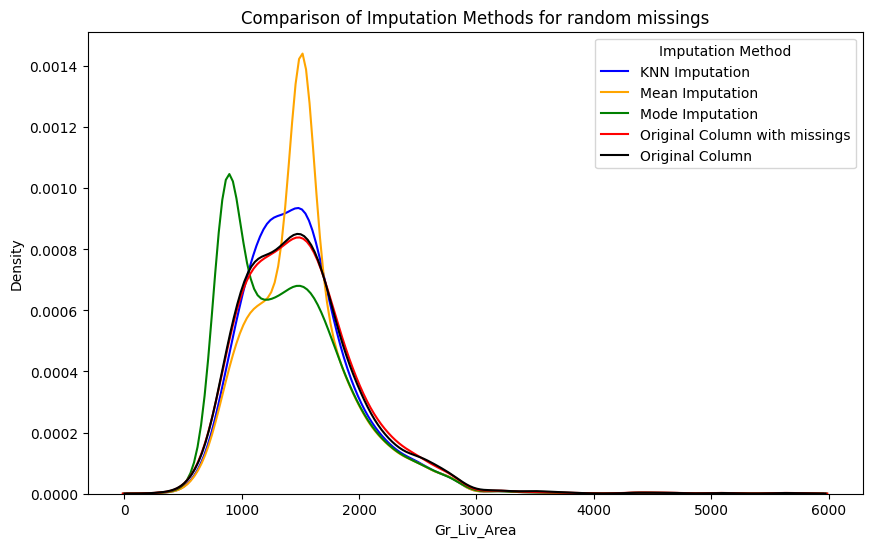

In [130]:
# lets compare the results of different imputation methods
# for variables which name starts with 'Gr_Liv_Area'
# (20% of randomly missing values)

# lets compare their distributions using overlaid density plots

plt.figure(figsize=(10, 6))
sns.kdeplot(data = houses_miss_train,
             x = 'Gr_Liv_Area_knn',
             label = 'KNN Imputation',
             color = 'blue')
sns.kdeplot(data = houses_miss_train,
             x = 'Gr_Liv_Area_mean',
             label = 'Mean Imputation',
             color = 'orange')
sns.kdeplot(data = houses_miss_train,
             x = 'Gr_Liv_Area_mode',
             label = 'Mode Imputation',
             color = 'green')
sns.kdeplot(data = houses_miss_train,
                x = 'Gr_Liv_Area_missing',
                    label = 'Original Column with missings',
                    color = 'red')
sns.kdeplot(data = houses_miss_train,
                x = 'Gr_Liv_Area',
                    label = 'Original Column',
                    color = 'black')
# Add the legend
plt.legend(title='Imputation Method')
plt.xlabel('Gr_Liv_Area')
plt.ylabel('Density')
plt.title('Comparison of Imputation Methods for random missings')
plt.show()

Looking at the density plot for Gr_Liv_Area with different imputation methods:

Observations:

Mean Imputation (orange) creates a sharp peak around the mean (≈1500), which is unrealistic—it distorts the original distribution.

Mode Imputation (green) also distorts the distribution, creating a peak around the most frequent value (≈1000).

KNN Imputation (blue) closely follows the original distribution (black line) across the range, preserving the shape and spread.

KNN Imputation is the best choice here because it maintains the original data distribution and avoids artificial spikes.

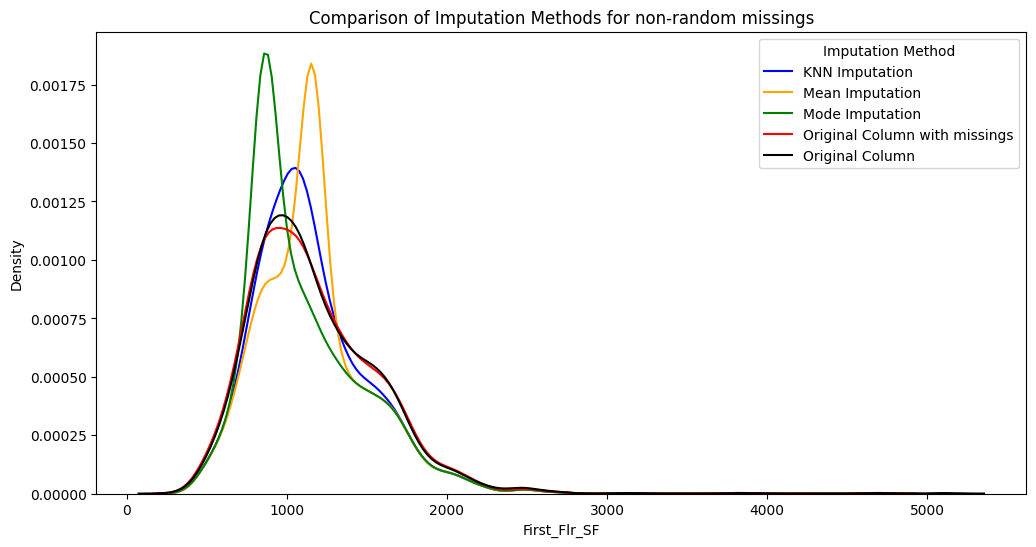

In [132]:
# and the same for variables which name starts with
# 'First_Flr_SF' (20% of non-randomly missing values)

plt.figure(figsize=(12, 6))
sns.kdeplot(data = houses_miss_train,
             x = 'First_Flr_SF_knn',
             label = 'KNN Imputation',
             color = 'blue')
sns.kdeplot(data = houses_miss_train,
             x = 'First_Flr_SF_mean',
             label = 'Mean Imputation',
             color = 'orange')
sns.kdeplot(data = houses_miss_train,
             x = 'First_Flr_SF_mode',
             label = 'Mode Imputation',
             color = 'green')
sns.kdeplot(data = houses_miss_train,
                x = 'First_Flr_SF_missing',
                    label = 'Original Column with missings',
                    color = 'red')
sns.kdeplot(data = houses_miss_train,
                x = 'First_Flr_SF',
                    label = 'Original Column',
                    color = 'black')
# Add the legend
plt.legend(title='Imputation Method')
plt.xlabel('First_Flr_SF')
plt.ylabel('Density')
plt.title('Comparison of Imputation Methods for non-random missings')
plt.show()